# Sensitivity Analysis
This script analysis how sensitive the overall seaweed growth model is to changes in the values for input parameters. 

In [5]:
# import the seaweed growth model equations
from src.model.seaweed_growth import (
    growth_factor_combination_single_value,
    illumination_single_value,
    nitrate_subfactor,
    phosphate_subfactor,
    ammonium_subfactor,
    salinity_single_value,
    temperature_single_value,
)

# Define the complete growth model
def growth_model(nitrate, phosphate, ammonium, salinity, temperature, illumination):
    """
    Calculates the growth factor for a single value
    Arguments:
        nitrate: the nitrate concentration in mmol/m³
        phosphate: the phosphate concentration in mmol/m³
        ammonium: the ammonium concentration in mmol/m³
        salinity: the salinity in PSU
        temperature: the temperature in °C
        illumination: the illumination in µmol/m²/s
    Returns:
        The growth factor as a float
    """
    # Calculate the subfactors
    nutrient_factor_value = min(
        nitrate_subfactor(nitrate), 
        phosphate_subfactor(phosphate), 
        ammonium_subfactor(ammonium)
    )
    salinity_factor_value = salinity_single_value(salinity)
    temperature_factor_value = temperature_single_value(temperature)
    illumination_factor_value = illumination_single_value(illumination)
    # Calculate the growth factor
    growth_factor = growth_factor_combination_single_value(
        nutrient_factor_value,
        salinity_factor_value,
        temperature_factor_value,
        illumination_factor_value
    )
    return growth_factor

To test the model, we simply call it with random values and see how this influences the results. The ranges of the values are based on how far those values differ in nature. To evaluate the sensitivity we can use the [Sobol method](https://www.sciencedirect.com/science/article/abs/pii/S0378475400002706). 

In [6]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 6,
    'names': ['nitrate', 'phosphate', 'ammonium', 'salinity', 'temperature', 'illumination'],
    'bounds': [[0, 2.5], [0, 2.5], [0, 2.5], [0, 60], [5, 40], [0, 600]]
}

# Generate the samples
param_values = saltelli.sample(problem, 100000)

# Run the model
growth_rate = np.array([growth_model(*X) for X in param_values])

# Perform the sensitivity analysis
Si = sobol.analyze(problem, growth_rate, print_to_console=True)


/tmp/ipykernel_21250/2442325824.py:14: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 100000)
/home/florian/local/anaconda3/envs/seaweed-growth-model/lib/python3.10/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100000) is equal to `2^n`.
        
  warnings.warn(msg)


                    ST   ST_conf
nitrate       0.080335  0.003769
phosphate     0.020507  0.002061
ammonium      0.061670  0.003633
salinity      0.599367  0.014746
temperature   0.529196  0.013822
illumination  0.327233  0.008926
                    S1   S1_conf
nitrate       0.014176  0.002019
phosphate     0.003685  0.000872
ammonium      0.011330  0.001976
salinity      0.223307  0.007600
temperature   0.176846  0.007130
illumination  0.082254  0.005255
                                   S2   S2_conf
(nitrate, phosphate)         0.001795  0.003733
(nitrate, ammonium)          0.003253  0.003766
(nitrate, salinity)          0.014270  0.004585
(nitrate, temperature)       0.013883  0.004062
(nitrate, illumination)      0.006817  0.004325
(phosphate, ammonium)       -0.000461  0.001412
(phosphate, salinity)        0.002085  0.001725
(phosphate, temperature)     0.001789  0.001774
(phosphate, illumination)    0.000777  0.001718
(ammonium, salinity)         0.009929  0.003486
(ammonium,

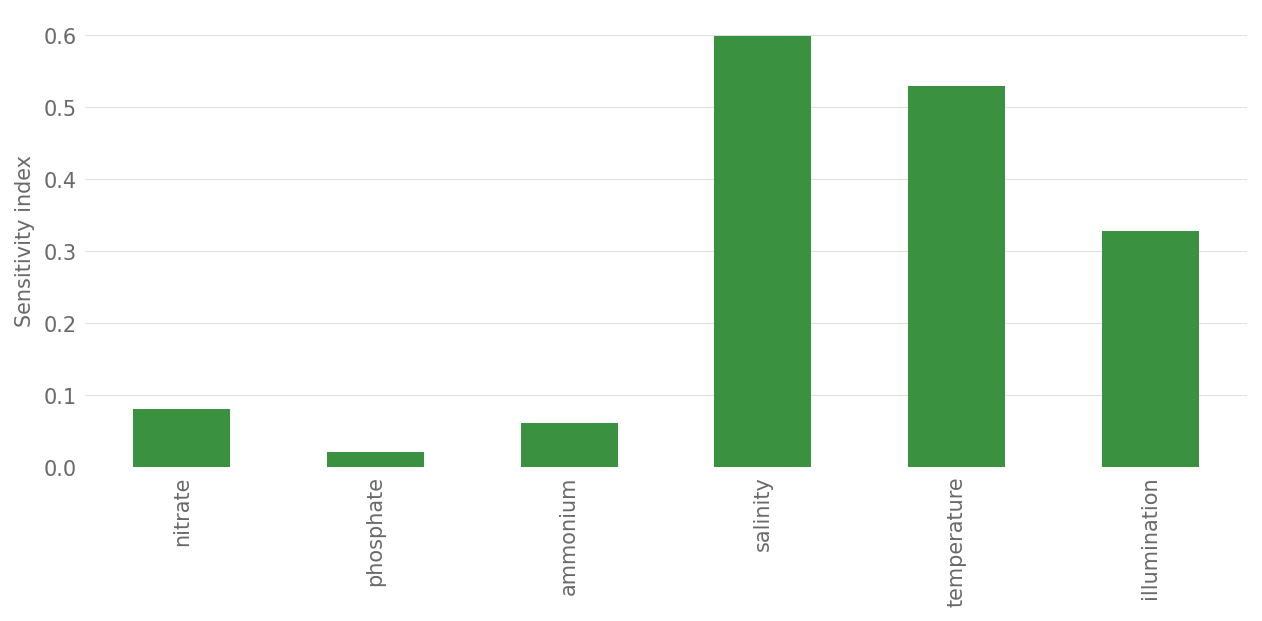

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(
    "https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle"
)

# Only use ST for the sensitivity analysis
df_Si = pd.DataFrame(Si['ST'], index=problem['names'], columns=['ST'])
ax = df_Si.plot.bar(legend=False)
ax.set_ylabel("Sensitivity index")
ax.xaxis.grid(False)

Definitions:

* S1: The first-order (main effect) Sobol indices. These indicate the sensitivity of the model's output to changes in each input parameter, taking into account only the main effects of the parameters (i.e., ignoring interactions between parameters).
* S2: The total-order Sobol indices. These indicate the sensitivity of the model's output to changes in each input parameter, taking into account both the main effects and the interactions between parameters.
* ST: The total Sobol indices. These indicate the sensitivity of the model's output to changes in each input parameter, taking into account both the main effects and the interactions between parameters, as well as the contributions of all other parameters.
* STi: The individual Sobol indices. These indicate the sensitivity of the model's output to changes in each input parameter, taking into account both the main effects and the interactions between parameters, as well as the contributions of all other parameters, with the contribution of each parameter removed.

So, we can see that salinity is the most sensitive parameter, followed by temperature and illumination. However, all the nutrients are relative insensitive. 